In [7]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import copy

#시각화
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import *

##알고리즘 

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## 모듈, 함수 가져오기
from Module.Preprocessing import *
from Module.Model import *

In [35]:
import matplotlib # 글자 깨짐 방지 폰트설정
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False   
#그래프에서 마이너스 기호가 표시되도록 하는 설정입니다.

# 데이터

## 데이터 불러오기

In [11]:
df_0 = pd.read_csv("d:/공모전/IPO/IPO/CleanData/X_train_Before_IPO.csv",encoding = 'cp949')
df = df_0.drop(['공모가 대비 3개월 수익률','공모가 대비 6개월 수익률'],axis =1)

In [13]:
## 기본 전처리
df['상장일'] = pd.to_datetime(df['상장일'])
df = df.set_index(['상장일'])
df = df.drop(['종목명','공모 시가총액'],axis = 1) ## 나중에 카테고리 진행할려면 남겨줄 것
df['Cat'] = Cut(df['공모가 대비 1개월 수익률'],[ -0.1, 0.1, 0.2])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 622 entries, 2009-04-07 to 2021-03-24
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   매출총이익률             622 non-null    float64 
 1   유동비율               622 non-null    float64 
 2   부채비율               622 non-null    float64 
 3   매출액증가율             622 non-null    float64 
 4   IPO_PER            622 non-null    float64 
 5   IPO_PBR            622 non-null    float64 
 6   IPO_EV/EBITDA      622 non-null    float64 
 7   1년 전 대비 시장수익률      622 non-null    float64 
 8   1년 전 대비 고객예탁금 증감률  622 non-null    float64 
 9   상장일 기준 국고3년시장금리    622 non-null    float64 
 10  공모가 대비 1개월 수익률     622 non-null    float64 
 11  Cat                622 non-null    category
dtypes: category(1), float64(11)
memory usage: 59.0 KB


In [15]:
X = df.drop(["공모가 대비 1개월 수익률","Cat"],axis=1)
y = df['Cat']

<AxesSubplot:>

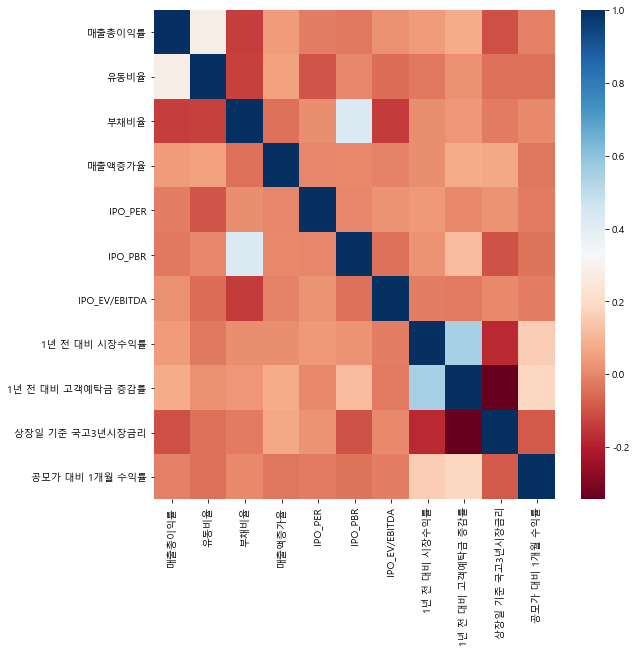

In [36]:
plt.figure(figsize =(9,9))
corr = df.corr()
sns.heatmap(corr,cmap='RdBu')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y,\
                                                    test_size=0.2,random_state=0)

In [20]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_train,y_train = smote.fit_resample(X_train,y_train)

# 모델링

## 랜덤포레스트

In [29]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
print("----랜덤포레스트 분류 모델 평가----")
get_clf_eval(y_test,pred)

----랜덤포레스트 분류 모델 평가----
정확도(accuracy): 0.4320, 정밀도(precision): 0.4418, 재현율(recall): 0.4320, f1_score: 0.4353


### 하이퍼파라미터 튜닝

In [30]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [10,200] ,
    'max_depth' : [4,5], 
    'min_samples_leaf' : [1,2,3,4, 8, 12 ,16],
    'min_samples_split' : [1,2,3,4, 8, 16,20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=5, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
최고 예측 정확도: 0.5409


### 튜닝된 파라미터로 재실행

In [32]:
# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf_2 = RandomForestClassifier(random_state=0 , max_depth = 5, min_samples_leaf = 1 , min_samples_split =  2 , n_estimators = 200)
rf_clf_2.fit(X_train , y_train)
pred = rf_clf_2.predict(X_test)
print("----랜덤포레스트 분류 모델 평가----")
get_clf_eval(y_test,pred)

----랜덤포레스트 분류 모델 평가----
정확도(accuracy): 0.3840, 정밀도(precision): 0.4121, 재현율(recall): 0.3840, f1_score: 0.3933


### feature importance 시각화

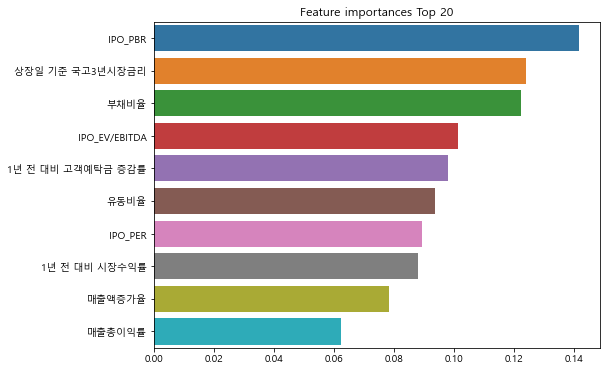

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf_2.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

## XGBoost

In [42]:
# 모델 학습
xgb_wrapper = XGBClassifier(random_state = 0)
xgb_wrapper.fit(X_train, y_train)

# predict  추출
pred = xgb_wrapper.predict(X_test)
print("----XGBoost 분류 모델 평가----")
get_clf_eval(y_test,pred)

[16:59:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
----XGBoost 분류 모델 평가----
정확도(accuracy): 0.3840, 정밀도(precision): 0.3660, 재현율(recall): 0.3840, f1_score: 0.3723


### 하이퍼 파라미터 튜닝

In [43]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "subsample": [0.8],
    "colsample_bytree": [0.5]
}

In [44]:
# Init classifier
xgb_cl = XGBClassifier(objective="multi:softprob")

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=5, scoring="accuracy")

# Fit
grid_cv.fit(X_train, y_train)

[17:01:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None

In [45]:
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 1, 'subsample': 0.8}
최고 예측 정확도: 0.6314


### 튜닝된 파라미터로 재실행

In [48]:
# 모델 학습
xgb_wrapper = XGBClassifier(random_state = 0,colsample_bytree = 0.5, gamma =  0,\
                            learning_rate =  0.1, max_depth =  3, reg_lambda =  0, subsample =  0.8 )
xgb_wrapper.fit(X_train, y_train)

# predict, predict_proba 추출
pred = xgb_wrapper.predict(X_test)
print("----XGBoost 분류 모델 평가----")
get_clf_eval(y_test,pred)

[17:01:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
----XGBoost 분류 모델 평가----
정확도(accuracy): 0.4160, 정밀도(precision): 0.4316, 재현율(recall): 0.4160, f1_score: 0.4214


### 하이퍼 파라미터 변화 후

In [49]:
# Insert the new fixed values to the grid
param_grid["subsample"] = (0.6,1.0)
param_grid["colsample_bytree"] = (0.5,1.0)

# Give new value ranges to other params
param_grid["gamma"] = (0.01,0.25)
param_grid["max_depth"] = (5,10)
param_grid["reg_lambda"] = (0,10)
param_grid["learning_rate"] = (0.01,0.3, 0.5)

In [50]:
grid_cv_2 = GridSearchCV(xgb_cl, param_grid, 
                         cv=5, scoring="accuracy", n_jobs=-1)

grid_cv_2.fit(X_train, y_train)

grid_cv_2.best_score_

[17:03:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6326048615903689

In [51]:
grid_cv_2.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.01,
 'learning_rate': 0.3,
 'max_depth': 10,
 'reg_lambda': 10,
 'subsample': 1.0}

### 튜닝된 파라미터로 재실행

In [52]:
# 모델 학습
xgb_wrapper = XGBClassifier(random_state = 0,colsample_bytree = 1, gamma =  0.01,\
                            learning_rate =  0.01, max_depth =  4, reg_lambda =  0, subsample =  1)
xgb_wrapper.fit(X_train, y_train)

# predict, predict_proba 추출
pred = xgb_wrapper.predict(X_test)
print("----XGBoost 분류 모델 평가----")
get_clf_eval(y_test,pred)

[17:03:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
----XGBoost 분류 모델 평가----
정확도(accuracy): 0.3520, 정밀도(precision): 0.4010, 재현율(recall): 0.3520, f1_score: 0.3643


### feature importance 시각화

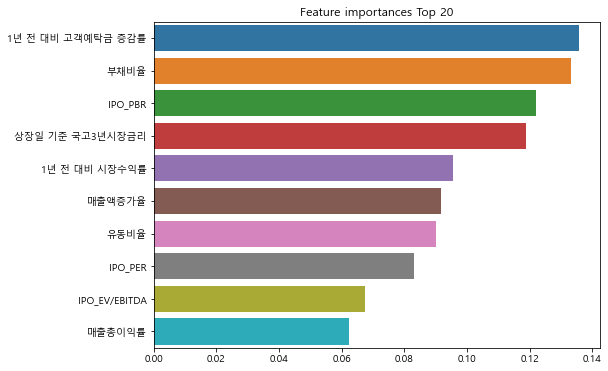

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = xgb_wrapper.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

## LGBM

In [54]:
# LGBM 분류기 객체 생성
lgbm_wrapper = LGBMClassifier(random_state = 0)

# 조기 중단 기능에 필요한 파라미터 정의
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)


# predict, predict_proba 추출
pred = lgbm_wrapper.predict(X_test)
print("----LGBM 분류 모델 평가----")
get_clf_eval(y_test,pred)

[1]	valid_0's multi_logloss: 1.35713
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 1.34607
[3]	valid_0's multi_logloss: 1.34155
[4]	valid_0's multi_logloss: 1.33611
[5]	valid_0's multi_logloss: 1.33372
[6]	valid_0's multi_logloss: 1.32496
[7]	valid_0's multi_logloss: 1.32217
[8]	valid_0's multi_logloss: 1.31783
[9]	valid_0's multi_logloss: 1.3133
[10]	valid_0's multi_logloss: 1.31897
[11]	valid_0's multi_logloss: 1.3168
[12]	valid_0's multi_logloss: 1.31853
[13]	valid_0's multi_logloss: 1.31462
[14]	valid_0's multi_logloss: 1.30682
[15]	valid_0's multi_logloss: 1.31234
[16]	valid_0's multi_logloss: 1.31913
[17]	valid_0's multi_logloss: 1.32056
[18]	valid_0's multi_logloss: 1.31968
[19]	valid_0's multi_logloss: 1.3248
[20]	valid_0's multi_logloss: 1.33631
[21]	valid_0's multi_logloss: 1.34139
[22]	valid_0's multi_logloss: 1.34507
[23]	valid_0's multi_logloss: 1.34883
[24]	valid_0's multi_logloss: 1.34865
[25]	valid_0's multi_logloss: 1.35022


### 하이퍼 파라미터 튜닝

In [55]:
param_grid = {
    'num_leaves': [31, 127,400],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

In [56]:
lgbm_wrapper = LGBMClassifier(boosting_type='gbdt' , objective ="multi:softprob", num_boost_round=2000, learning_rate=0.01)

grid_cv = GridSearchCV(lgbm_wrapper, param_grid, n_jobs=-1, cv=3, scoring="accuracy")

# Fit
grid_cv.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000


GridSearchCV(cv=3,
             estimator=LGBMClassifier(learning_rate=0.01, num_boost_round=2000,
                                      objective='multi:softprob'),
             n_jobs=-1,
             param_grid={'lambda_l1': [0, 1, 1.5], 'lambda_l2': [0, 1],
                         'min_data_in_leaf': [30, 50, 100, 300, 400],
                         'num_leaves': [31, 127, 400],
                         'reg_alpha': [0.1, 0.5]},
             scoring='accuracy')

In [57]:
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'lambda_l1': 0, 'lambda_l2': 0, 'min_data_in_leaf': 30, 'num_leaves': 31, 'reg_alpha': 0.1}
최고 예측 정확도: 0.6263


### 튜닝된 파라미터로 재실행

In [58]:
# 모델 학습
lgbm_wrapper = LGBMClassifier(random_state = 0,lamnda_l1 = 0 , lamda_l2 = 1, min_data_in_leaf = 50 , num_leaves = 31, reg_alpha = 0.1)
lgbm_wrapper.fit(X_train, y_train)

# predict, predict_proba 추출
pred = lgbm_wrapper.predict(X_test)
print("----lgbm  분류 모델 평가----")
get_clf_eval(y_test,pred)

----lgbm  분류 모델 평가----
정확도(accuracy): 0.3920, 정밀도(precision): 0.3885, 재현율(recall): 0.3920, f1_score: 0.3901


### feature importance 시각화

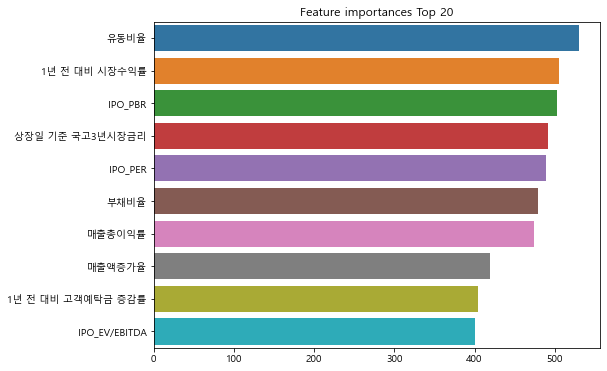

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = lgbm_wrapper.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()